In [441]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [442]:
%cd /content/drive/MyDrive/Colab\ Notebooks/MIR/Assignment1

/content/drive/MyDrive/Colab Notebooks/MIR/Assignment1


In [5]:
#If not installed, install Essentia. 
# This cell is for running the notebook in Colab
import importlib.util
if importlib.util.find_spec('essentia') is None:
  !pip install essentia

     |████████████████████████████████| 12.0MB 264kB/s 


In [6]:
#Basic imports
import os
import matplotlib.pyplot as plt
import essentia.standard as ess
import numpy as np


## Collecting raw data and investigating its nature

### Downloading dataset files

In [ ]:
# download the Mridangam Stroke dataset
!wget "https://zenodo.org/record/1265188/files/mridangam_stroke_1.0.zip?download=1" -O dataset.zip

--2021-01-31 12:19:58--  https://zenodo.org/record/1265188/files/mridangam_stroke_1.0.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143111120 (136M) [application/octet-stream]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 136.48M  32.4MB/s    in 4.3s    

2021-01-31 12:20:03 (31.4 MB/s) - ‘dataset.zip’ saved [143111120/143111120]



In [ ]:
# unzip the dataset
import zipfile

filename = 'dataset.zip'
zip_ref = zipfile.ZipFile(filename, 'r')
zip_ref.extractall()
zip_ref.close()
os.remove(filename)#Removing the zip file

**Collect file lists for each Stroke** **bold text**

In [9]:
#main_data_dir = 'mridangam_stroke_1.0'
main_data_dir = 'mridangam_stroke_1.0'
stroke_files = dict()#dictionary containing for each instrument a list that carries dictionaries
note_files = dict()
for root, dirs, files in os.walk(main_data_dir):
    for file in files:
        #Let's only keep forte recordings indicated with .ff. in the file name
        if (file.endswith('.wav')):
            stroke = file.split('__')[2].split('-')[0]
            note = root.split('/')[1]
            file_name = os.path.join(root,file)
            files_note = note_files.get(note)
            files_stroke = stroke_files.get(stroke)
            if files_note == None:
                files_note = [file_name]
            else:
                files_note.append(file_name)
            if files_stroke == None:
                files_stroke = [file_name]
            else:
                files_stroke.append(file_name)
            note_files[note] = files_note
            stroke_files[stroke] = files_stroke
            

#Let's print the list of files
stroke_files

{'bheem': ['mridangam_stroke_1.0/B/224034__akshaylaya__bheem-b-005.wav',
  'mridangam_stroke_1.0/B/224033__akshaylaya__bheem-b-004.wav',
  'mridangam_stroke_1.0/B/224032__akshaylaya__bheem-b-003.wav',
  'mridangam_stroke_1.0/B/224031__akshaylaya__bheem-b-002.wav',
  'mridangam_stroke_1.0/B/224030__akshaylaya__bheem-b-001.wav',
  'mridangam_stroke_1.0/C/225358__akshaylaya__bheem-c-003.wav',
  'mridangam_stroke_1.0/C/225357__akshaylaya__bheem-c-002.wav',
  'mridangam_stroke_1.0/C/225356__akshaylaya__bheem-c-001.wav',
  'mridangam_stroke_1.0/C#/226488__akshaylaya__bheem-csh-001.wav',
  'mridangam_stroke_1.0/D#/228639__akshaylaya__bheem-dsh-015.wav',
  'mridangam_stroke_1.0/D#/228637__akshaylaya__bheem-dsh-013.wav',
  'mridangam_stroke_1.0/D#/228636__akshaylaya__bheem-dsh-012.wav',
  'mridangam_stroke_1.0/D#/228635__akshaylaya__bheem-dsh-011.wav',
  'mridangam_stroke_1.0/D#/228634__akshaylaya__bheem-dsh-010.wav',
  'mridangam_stroke_1.0/D#/228633__akshaylaya__bheem-dsh-009.wav',
  'mridang

In [10]:
note_files

{'B': ['mridangam_stroke_1.0/B/224938__akshaylaya__thi-b-157.wav',
  'mridangam_stroke_1.0/B/224937__akshaylaya__thi-b-156.wav',
  'mridangam_stroke_1.0/B/224936__akshaylaya__thi-b-155.wav',
  'mridangam_stroke_1.0/B/224935__akshaylaya__thi-b-154.wav',
  'mridangam_stroke_1.0/B/224933__akshaylaya__thi-b-152.wav',
  'mridangam_stroke_1.0/B/224932__akshaylaya__thi-b-151.wav',
  'mridangam_stroke_1.0/B/224931__akshaylaya__thi-b-150.wav',
  'mridangam_stroke_1.0/B/224930__akshaylaya__thi-b-149.wav',
  'mridangam_stroke_1.0/B/224928__akshaylaya__thi-b-147.wav',
  'mridangam_stroke_1.0/B/224927__akshaylaya__thi-b-146.wav',
  'mridangam_stroke_1.0/B/224926__akshaylaya__thi-b-145.wav',
  'mridangam_stroke_1.0/B/224923__akshaylaya__thi-b-142.wav',
  'mridangam_stroke_1.0/B/224922__akshaylaya__thi-b-141.wav',
  'mridangam_stroke_1.0/B/224920__akshaylaya__thi-b-139.wav',
  'mridangam_stroke_1.0/B/224918__akshaylaya__thi-b-137.wav',
  'mridangam_stroke_1.0/B/224917__akshaylaya__thi-b-136.wav',
  '

**Collect file lists for each Note** **bold text**

### Investigating and preprocessing raw data

It is often very useful to first check a few samples from the dataset to decide what preprocessing steps are required. Let's have a look at the waveform of one sample recording for each instrument

In [ ]:
fs = 44100
def plot_one_each(audio_dict, fs = 44100):
  # And for the strokes

  num_instruments = len(audio_dict.keys())
  print("Sample waveform plots")
  plt.figure(1, figsize=(5 * num_instruments, 3))
  file_ind_inlist = 0 # 0: let's take the first file in the list for sample plots
  for i,instrument in enumerate(audio_dict.keys()):
      sample_file = audio_dict[instrument][file_ind_inlist]
      x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
      
      plt.subplot(1,num_instruments,(i+1))
      plt.plot(x)
      plt.title(instrument)

Sample waveform plots


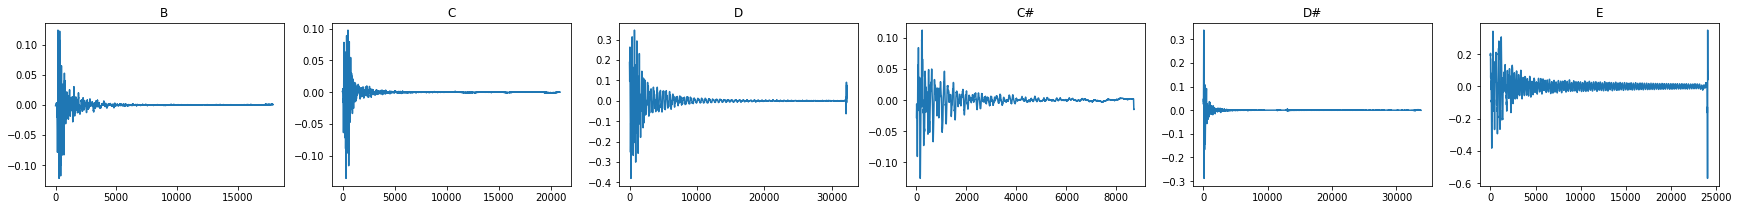

In [ ]:
plot_one_each(note_files)

Sample waveform plots


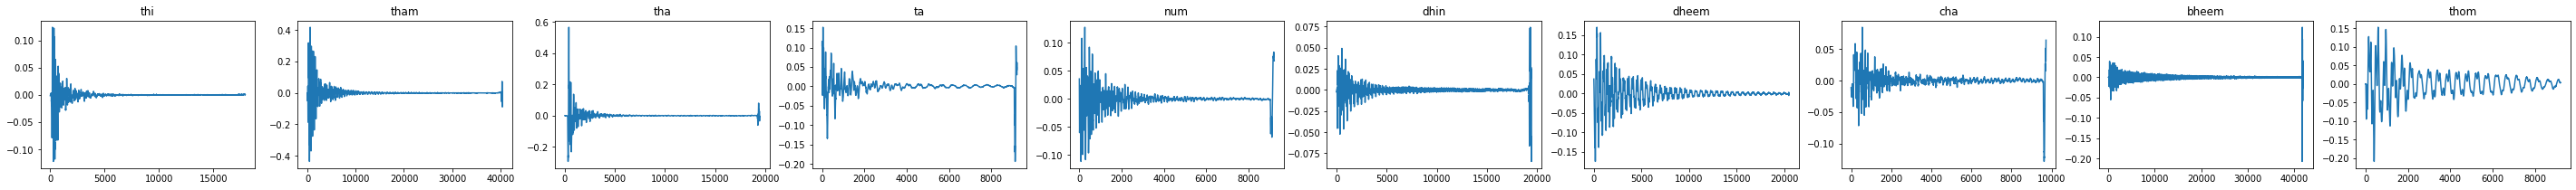

In [ ]:
# And for the strokes
plot_one_each(stroke_files)

In [ ]:
# Raw-data preprocess analysis parameters
windowSize = 1024
hopSize = 1024
NRG_threshold_ratio = 0.01 #threshold expressed as ratio with respect to the maximum value
#Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}

In [ ]:
#Function definition
def split_file(filename, params):
    '''Function to define split boundaries based on a fixed energy threshold
    '''
    x = ess.MonoLoader(filename = filename, sampleRate = fs)()
    NRG = [];
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)
    
    #Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > NRG_threshold_ratio] = 1
    #Setting segment boundaries
    #Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)
    #Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize
    #Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize

    return (x, NRG, split_decision_func, start_indexes, stop_indexes)

Let's visualize five files per instrument to check if the splits look fine.

In [ ]:
def energy_env_plot(audio_dict):
  num_instruments = len(audio_dict.keys())
  print("Sample plots for waveform versus energy and splits based on energy threshold")

  file_indexes = [0, 1, 2, 3, 4]
  for file_ind_inlist in file_indexes:
      plt.figure(file_ind_inlist, figsize=(5 * num_instruments, 3))
      for i, instrument in enumerate(audio_dict.keys()):
          sample_file = audio_dict[instrument][file_ind_inlist]
          (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
          #Plotting functions for checking the split decisions
          plt.subplot(1,num_instruments,(i+1))
          plt.title(instrument)
          plt.plot(x, label = 'sound waveform')
          plt.plot(np.arange(NRG.size) * hopSize, NRG, 'g', label = 'NRG')
          plt.plot(np.arange(split_decision_func.size) * hopSize, split_decision_func,'r', label = 'split function')
          plt.vlines(start_indexes, ymin = -0.5, ymax = 0, colors='b', linestyles='solid', label='Segment start')
          plt.vlines(stop_indexes, ymin = -0.5, ymax = 0, colors='k', linestyles='dashed', label='Segment stop')

  plt.legend(loc="best");

Sample plots for waveform versus energy and splits based on energy threshold


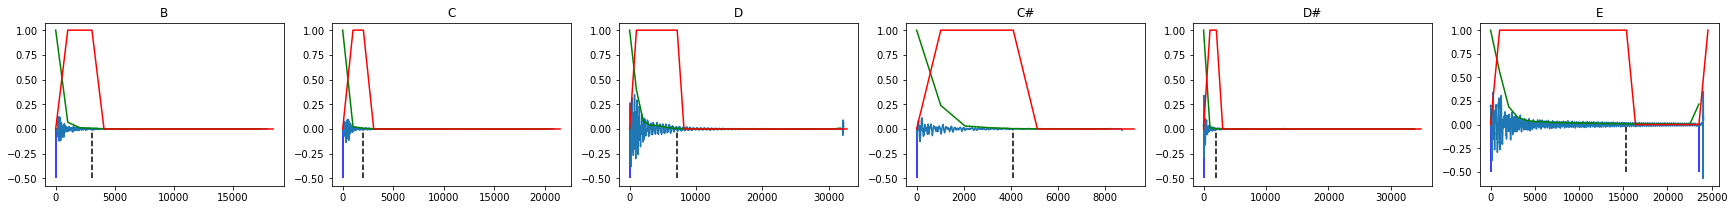

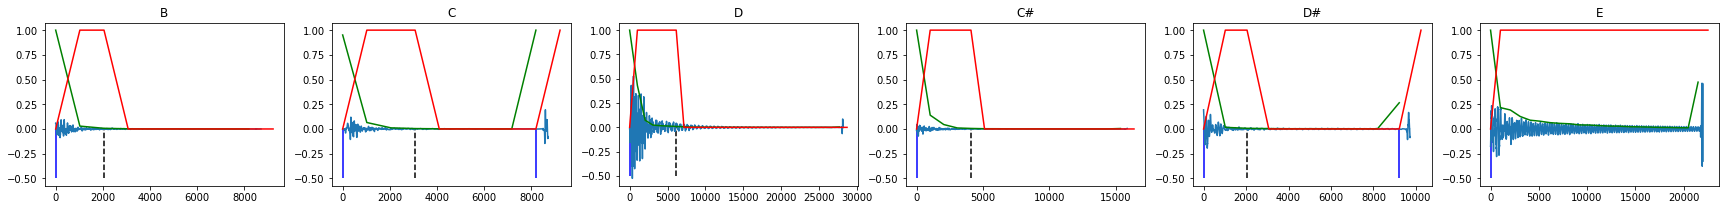

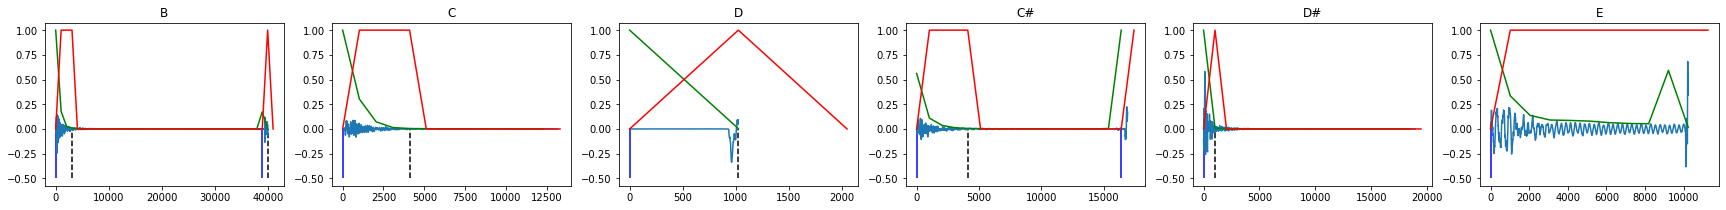

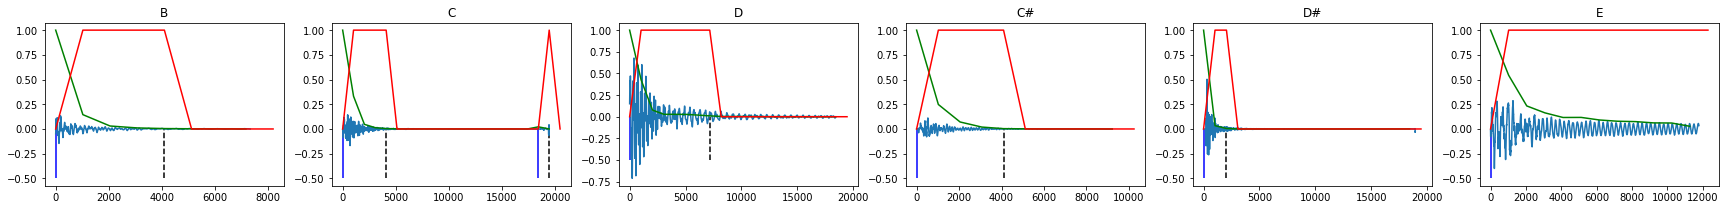

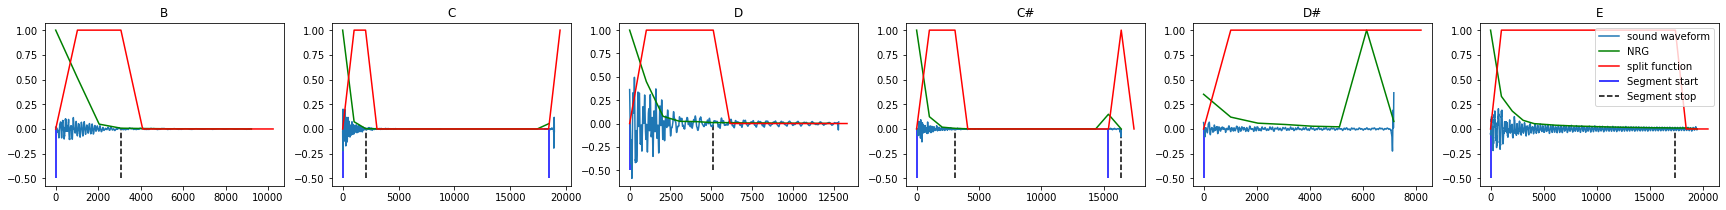

In [ ]:
energy_env_plot(note_files)

Sample plots for waveform versus energy and splits based on energy threshold


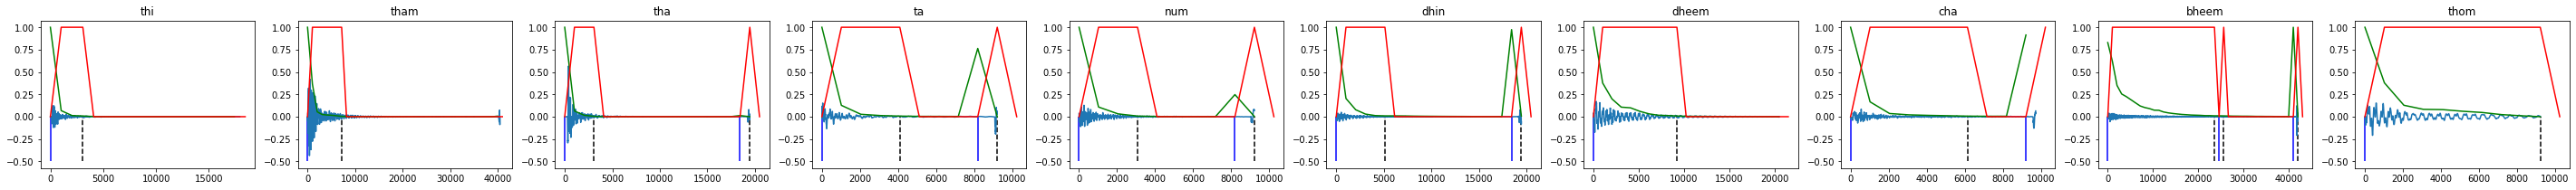

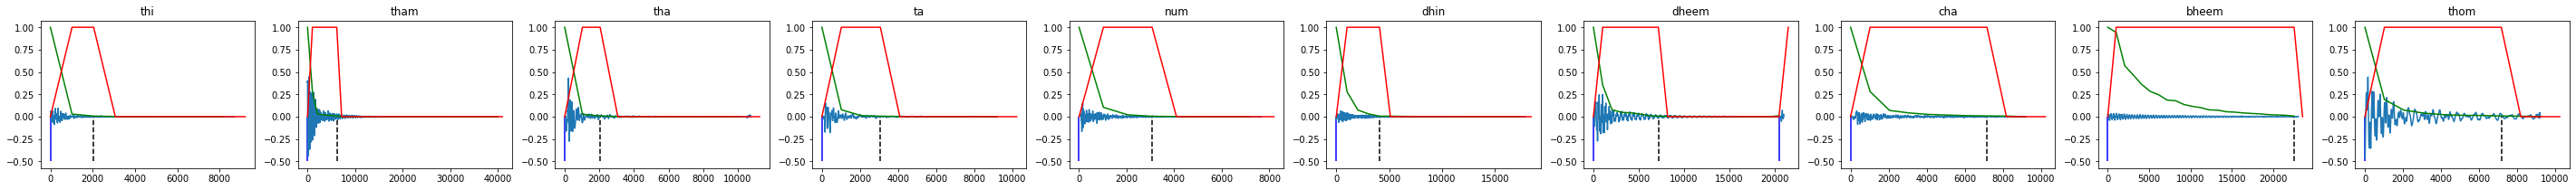

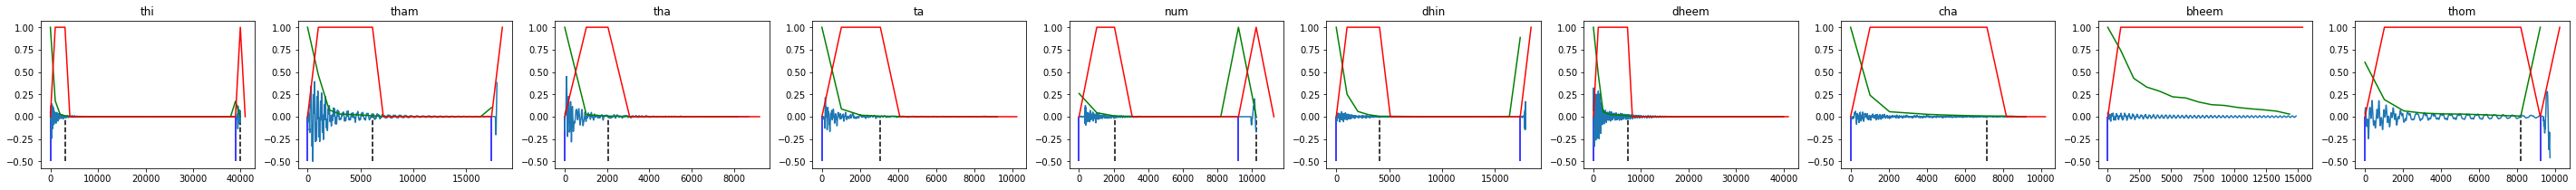

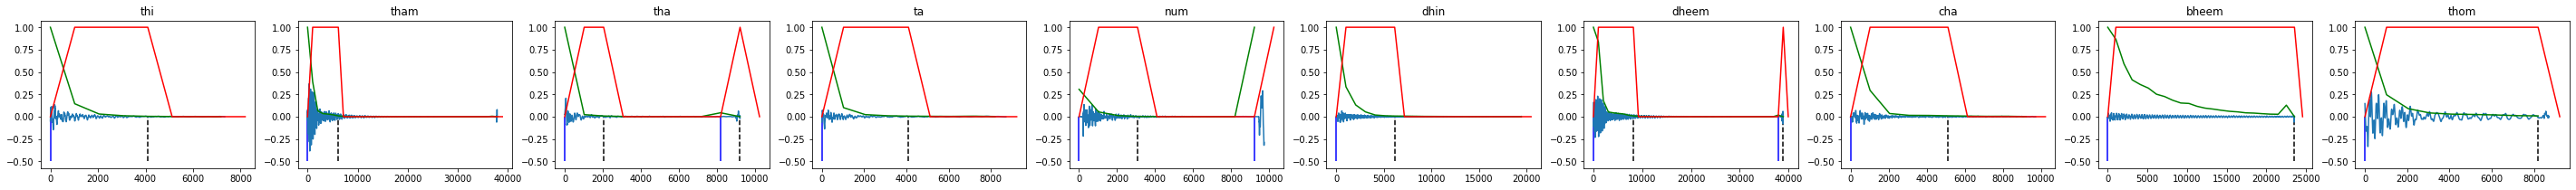

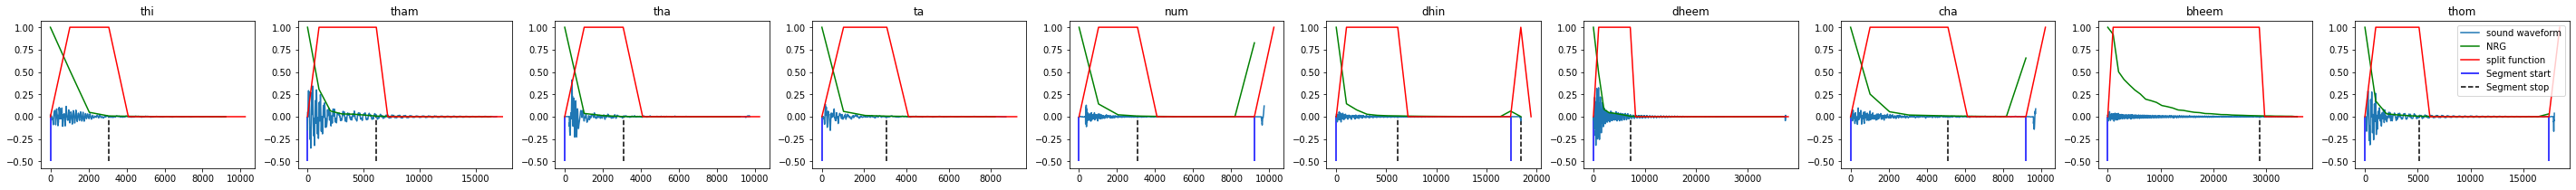

In [ ]:
# and the strokes:
energy_env_plot(stroke_files)

The decision boundaries look fine, let's use the function to 
* get segment boundaries and crop segments, 
* amplitude normalize them and save all segments in a new folder

In [ ]:
def segment_dictionary(audio_dict, output_path):
  if not os.path.exists(output_path):#creating the directory
    os.mkdir(output_path)

  segment_files = []
  for instrument, files in audio_dict.items():
      file_count = 0
      total = len(files)
      for sample_file in files:
          if file_count % 20 == 0:
              print("cropping", instrument, file_count, '/',total)
          x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
          (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
          #Croping segments
          if not(len(stop_indexes) == 0 or len(stop_indexes) == 0):
              # as all the samples are strokes we return just the first
              # start and stop indexes. Any other index is a pop at the end of the recording
              stop = stop_indexes[0]
              start = start_indexes[0]        
              x_seg = x[start: stop]
              #Final check for amplitude (to avoid silent segments selection due to noise in split function)
              if(np.max(np.abs(x_seg)) > 0.05):
                  #Amplitude normalisation
                  x_seg = x_seg / np.max(np.abs(x_seg))
                  filename = os.path.join(output_path, instrument + '_' + str(file_count) + '.wav')
                  ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(x_seg)
                  file_count +=1
                  segment_files.append(filename)
  
  print(len(segment_files),'segment files created')

  return segment_files

In [ ]:
note_dir = os.path.join('segments_note')
note_segment_files = segment_dictionary(note_files, note_dir)

cropping  B 0 / 1325
cropping  B 20 / 1325
cropping  B 40 / 1325
cropping  B 60 / 1325
cropping  B 80 / 1325
cropping  B 100 / 1325
cropping  B 120 / 1325
cropping  B 140 / 1325
cropping  B 160 / 1325
cropping  B 180 / 1325
cropping  B 200 / 1325
cropping  B 220 / 1325
cropping  B 240 / 1325
cropping  B 260 / 1325
cropping  B 280 / 1325
cropping  B 300 / 1325
cropping  B 320 / 1325
cropping  B 340 / 1325
cropping  B 360 / 1325
cropping  B 380 / 1325
cropping  B 400 / 1325
cropping  B 420 / 1325
cropping  B 440 / 1325
cropping  B 460 / 1325
cropping  B 480 / 1325
cropping  B 500 / 1325
cropping  B 520 / 1325
cropping  B 540 / 1325
cropping  B 560 / 1325
cropping  B 580 / 1325
cropping  B 600 / 1325
cropping  B 620 / 1325
cropping  B 640 / 1325
cropping  B 660 / 1325
cropping  B 660 / 1325
cropping  B 660 / 1325
cropping  B 680 / 1325
cropping  B 700 / 1325
cropping  B 720 / 1325
cropping  B 740 / 1325
cropping  B 760 / 1325
cropping  B 780 / 1325
cropping  B 800 / 1325
cropping  B 820 /

In [ ]:
stroke_dir = os.path.join('segments_stroke')
stroke_segment_files = segment_dictionary(stroke_files, stroke_dir)

cropping thi 0 / 2213
cropping thi 20 / 2213
cropping thi 40 / 2213
cropping thi 60 / 2213
cropping thi 80 / 2213
cropping thi 100 / 2213
cropping thi 120 / 2213
cropping thi 140 / 2213
cropping thi 160 / 2213
cropping thi 180 / 2213
cropping thi 200 / 2213
cropping thi 220 / 2213
cropping thi 240 / 2213
cropping thi 260 / 2213
cropping thi 280 / 2213
cropping thi 300 / 2213
cropping thi 320 / 2213
cropping thi 340 / 2213
cropping thi 360 / 2213
cropping thi 380 / 2213
cropping thi 400 / 2213
cropping thi 420 / 2213
cropping thi 440 / 2213
cropping thi 460 / 2213
cropping thi 480 / 2213
cropping thi 500 / 2213
cropping thi 520 / 2213
cropping thi 540 / 2213
cropping thi 560 / 2213
cropping thi 580 / 2213
cropping thi 600 / 2213
cropping thi 620 / 2213
cropping thi 640 / 2213
cropping thi 660 / 2213
cropping thi 680 / 2213
cropping thi 700 / 2213
cropping thi 720 / 2213
cropping thi 740 / 2213
cropping thi 760 / 2213
cropping thi 780 / 2213
cropping thi 800 / 2213
cropping thi 820 / 221

In [11]:
def load_segments_dict(segmented_data_dir):
  """
  loads in memory the cropped audio dictonary from the path
  """
  segment_files = []
  # Check cropping:
  #main_data_dir = 'mridangam_stroke_1.0'
  main_data_dir = segmented_data_dir
  inst_files_seg = dict()#dictionary containing for each instrument a list that carries dictionaries
  for root, dirs, files in os.walk(main_data_dir):
      for file in files:
          #Let's only keep forte recordings indicated with .ff. in the file name
          if (file.endswith('.wav')):
              # print(file)
              note = file.split('_')[0]
              file_name = os.path.join(root,file)
              segment_files.append(file_name)
              # files_instrument = inst_files_seg.get(note)
              # if files_instrument == None:
              #     files_instrument = [file_name]
              # else:
              #     files_instrument.append(file_name)
              # inst_files_seg[note] = files_instrument

  #Let's print the list of files
  return segment_files

In [12]:
# if the runtime stops we would like to re-load the segments dictionary in memory
# without processing them all again
stroke_dir = os.path.join('segments_stroke')
stroke_segment_files = load_segments_dict(stroke_dir)

note_dir = os.path.join('segments_note')
note_segment_files = load_segments_dict(note_dir)

In [17]:
print(len(note_segment_files))
print(len(stroke_segment_files))

6861
6861


Segments saved into separate files.

## Feature extraction 

Let's compute a list of common features for each of the files and form a data frame including features and categories. We will be using the [MusicExtractor function of Essentia](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html) that would compute a large number of features commonly used in MIR literature. 

Let's first run it for a file and check its output:

In [ ]:
import essentia.standard as es

#Running music extractor for a file:
file = note_segment_files[0]#simply pick the first file in the list
features, features_frames = es.MusicExtractor(lowlevelSilentFrames='drop',
                                                  lowlevelFrameSize = 2048,
                                                  lowlevelHopSize = 1024,
                                                  lowlevelStats = ['mean', 'stdev'])(file)

Essentia-MusicExtractor extracts a large number of features. For simplicity, let's only keep low-level descriptors which are represented with a single scalar value as our feature set and discard other features.

In [ ]:
scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

Running musicextractor for all files, keeping a subset of features, writing to an output file: data.csv

In [ ]:
def extract_features(segment_files, segments_dir):
  #Extracting features and writing in data.csv file in the segments folder
  #  each line in the data.csv file represents a sample with features and the class information as the last element
  data_file = os.path.join(segments_dir,'data.csv')
  file_count = 0
  with open(data_file, 'w') as writer:
      #adding column names as the first line in csv
      line2write = ','.join(scalar_lowlevel_descriptors + ['instrument']).replace('lowlevel.','') + '\n'
      writer.write(line2write)
      for file in segment_files:
          if '.wav' in file:
              file_count +=1
              if file_count % 20 == 0:#print name of a file every 20 files
                  print(file_count, "files processed, current file: ",file)
              features, features_frames = es.MusicExtractor(lowlevelSilentFrames='drop',
                                                            lowlevelFrameSize = 2048,
                                                            lowlevelHopSize = 1024,
                                                            lowlevelStats = ['mean', 'stdev'])(file)
              selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
              instrument = file.split('/')[-1].split('_')[0].lower()#note information
              line2write = str(selected_features)[1:-1] + ',' + instrument + '\n'
              writer.write(line2write)
  print("A total of ",file_count, "files processed")

In [ ]:
extract_features(note_segment_files, note_dir)

20 files processed, current file:  segments_note/B_19.wav
40 files processed, current file:  segments_note/B_39.wav
60 files processed, current file:  segments_note/B_59.wav
80 files processed, current file:  segments_note/B_79.wav
100 files processed, current file:  segments_note/B_99.wav
120 files processed, current file:  segments_note/B_119.wav
140 files processed, current file:  segments_note/B_139.wav
160 files processed, current file:  segments_note/B_159.wav
180 files processed, current file:  segments_note/B_179.wav
200 files processed, current file:  segments_note/B_199.wav
220 files processed, current file:  segments_note/B_219.wav
240 files processed, current file:  segments_note/B_239.wav
260 files processed, current file:  segments_note/B_259.wav
280 files processed, current file:  segments_note/B_279.wav
300 files processed, current file:  segments_note/B_299.wav
320 files processed, current file:  segments_note/B_319.wav
340 files processed, current file:  segments_note

In [ ]:
extract_features(stroke_segment_files, stroke_dir)

20 files processed, current file:  segments_stroke/thi_19.wav
40 files processed, current file:  segments_stroke/thi_39.wav
60 files processed, current file:  segments_stroke/thi_59.wav
80 files processed, current file:  segments_stroke/thi_79.wav
100 files processed, current file:  segments_stroke/thi_99.wav
120 files processed, current file:  segments_stroke/thi_119.wav
140 files processed, current file:  segments_stroke/thi_139.wav
160 files processed, current file:  segments_stroke/thi_159.wav
180 files processed, current file:  segments_stroke/thi_179.wav
200 files processed, current file:  segments_stroke/thi_199.wav
220 files processed, current file:  segments_stroke/thi_219.wav
240 files processed, current file:  segments_stroke/thi_239.wav
260 files processed, current file:  segments_stroke/thi_259.wav
280 files processed, current file:  segments_stroke/thi_279.wav
300 files processed, current file:  segments_stroke/thi_299.wav
320 files processed, current file:  segments_stro

## Analysis and preprocessing of features

All extracted features are saved in data.csv. Columns represent features and rows files/samples. This is a typical format in a large number of machine learning datasets (see a few of the dataset here: https://archive.ics.uci.edu/ml/index.php or other "Data Science" examples on the web).  

***The use of a common format for data representation is beneficial in both making use of existing tools/libraries (such as Pandas) and contributing to the community with resources that are easy to use.***

Let's load the data and start investigating the features. We can use Pandas (a package largely used in data science) to read data and access statistical description of the features. 

In [56]:
import pandas as pd
import os
import numpy as np

In [57]:
# %cd /content/drive/MyDrive/Colab\ Notebooks/MIR/Assignment1/mridangam_stroke_1.0

In [58]:
#Read data
data_file = os.path.join('segments_note','data.csv')
data_note = pd.read_csv(data_file)
#Let's see the first lines of our data
data_note.tail(-6000)

average_loudness  ...  instrument
6000          0.990684  ...           e
6001          0.990684  ...           e
6002          0.990684  ...           e
6003          0.990684  ...           e
6004          0.990684  ...           e
...                ...  ...         ...
6856          0.990684  ...           e
6857          0.990684  ...           e
6858          0.990684  ...           e
6859          0.990684  ...           e
6860          0.990684  ...           e

[861 rows x 85 columns]

In [59]:
#Read data strokes
data_file = os.path.join('segments_stroke','data.csv')
data_stroke = pd.read_csv(data_file)
#Let's see the first lines of our data
data_stroke.tail(-6000)

average_loudness  ...  instrument
6000          0.990684  ...         cha
6001          0.990684  ...         cha
6002          0.990684  ...         cha
6003          0.990684  ...         cha
6004          0.990684  ...         cha
...                ...  ...         ...
6856          0.990684  ...        thom
6857          0.990684  ...        thom
6858          0.990684  ...        thom
6859          0.990684  ...        thom
6860          0.990684  ...        thom

[861 rows x 85 columns]

All features are represented with columns, and the last column ('instrument') carries the class information.

Always check if your data involves NaN values and clean them (by simply removing the sample, or replacing the NaN value by a real value (such as the median of that feature)).

In [60]:
data_note.isnull().sum().sum()#sums a matrix of True/False values obtained by checking if each value is Nan

0

In [61]:
data_stroke.isnull().sum().sum()#sums a matrix of True/False values obtained by checking if each value is Nan

0

**Observation:** No NaN value, proceed ..

We can plot samples on two-dimensional feature spaces to check if features are discriminative for those classes. Here is an example:

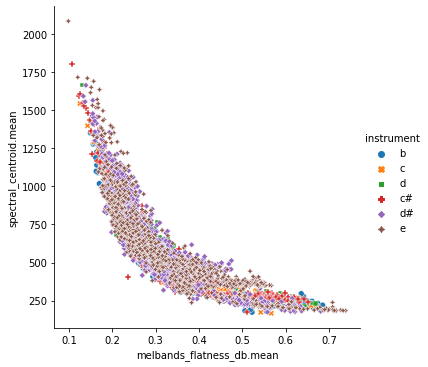

In [62]:
import seaborn as sns
# for the notes:
sns.relplot(x = "melbands_flatness_db.mean", y = "spectral_centroid.mean", hue = "instrument", style = "instrument", data = data_note);

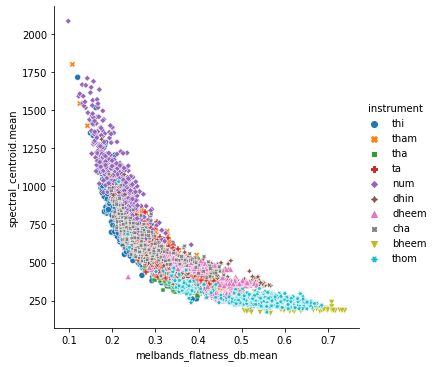

In [38]:
# strokes:
sns.relplot(x = "melbands_flatness_db.mean", y = "spectral_centroid.mean", hue = "instrument", style = "instrument", data = data_stroke);

The Seaborn package includes some very useful plotting functions that facilitate such visual inspections. Here is another example: this time producing plots **for the last 6 features**, creating all combinations to form 2-dimensional feature spaces representing the samples from different classes

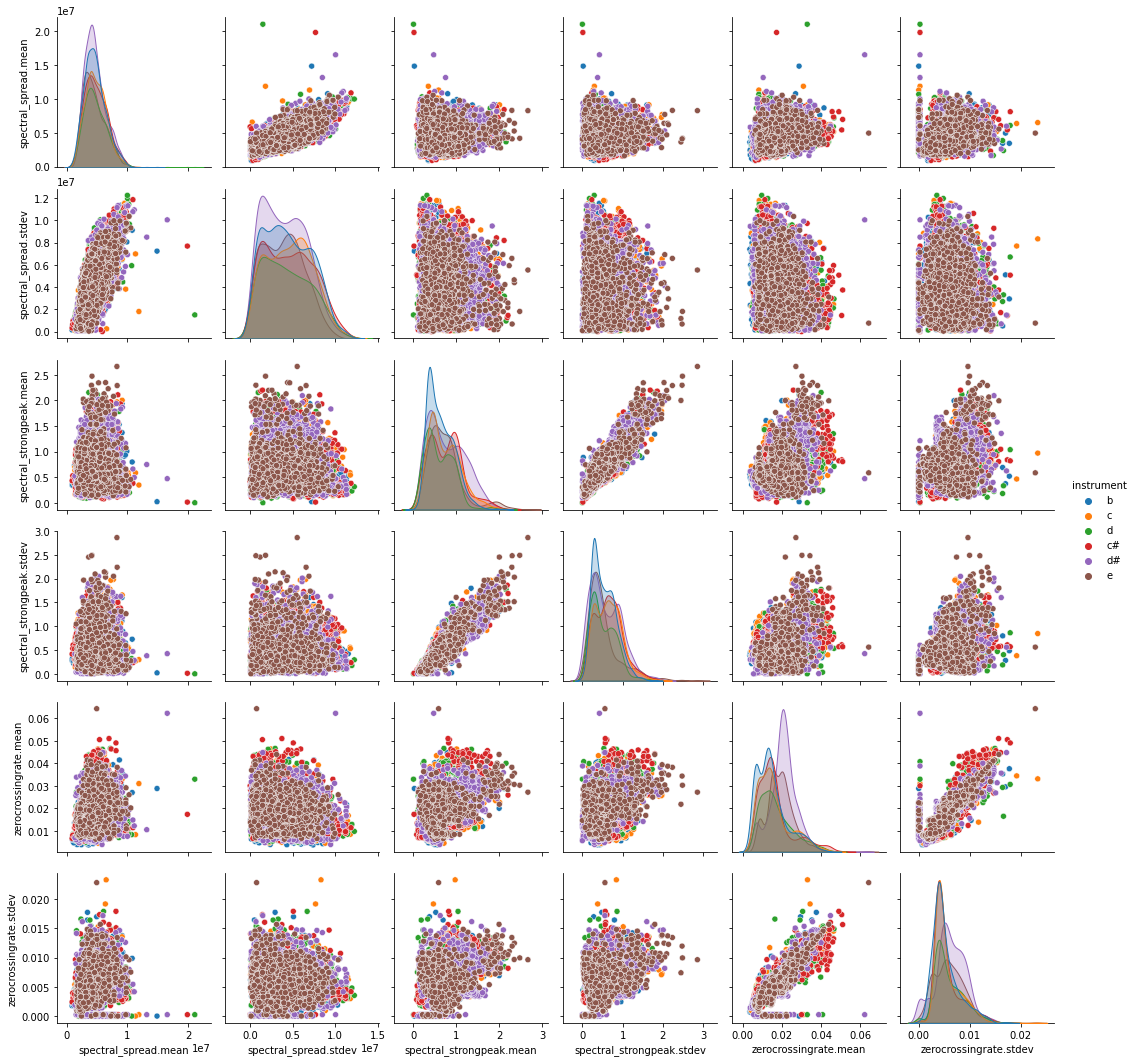

In [39]:
# notes:
sns.pairplot(data_note.iloc[:, -7:], hue = "instrument");

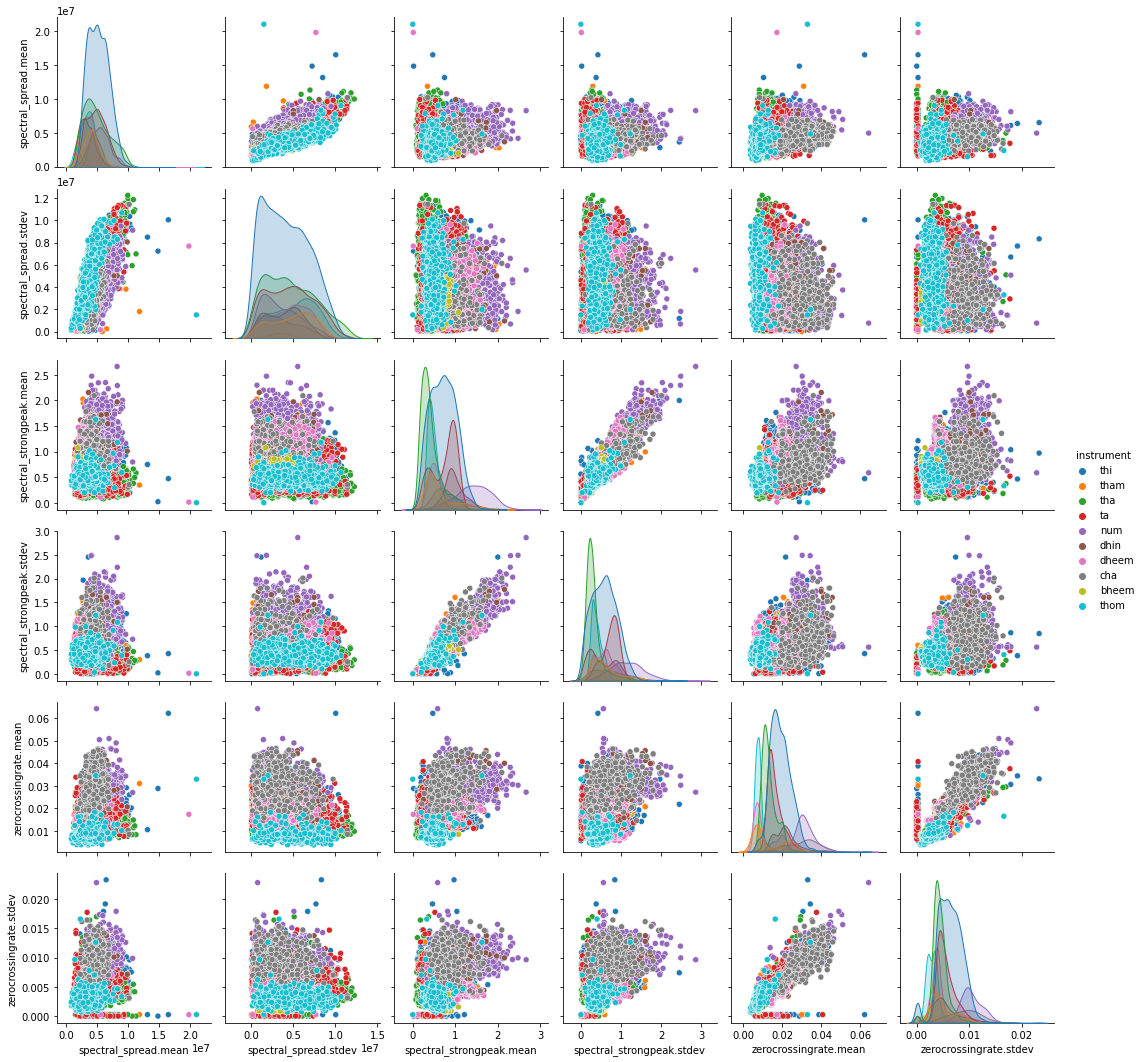

In [40]:
# strokes:
sns.pairplot(data_stroke.iloc[:, -7:], hue = "instrument");

As the next step, having a look at descriptive statistics of the features would be useful. Let's do that:

In [63]:
#Descriptive statistics of the features:
data_note.describe()

average_loudness  ...  zerocrossingrate.stdev
count       6861.000000  ...             6861.000000
mean           0.990684  ...                0.005708
std            0.000000  ...                0.002806
min            0.990684  ...                0.000000
25%            0.990684  ...                0.003788
50%            0.990684  ...                0.005003
75%            0.990684  ...                0.007409
max            0.990684  ...                0.023318

[8 rows x 84 columns]

In [64]:
# strokes has the same distribution except for the labels because are the same
# cropped audio files

**Observation:** min, max, mean values of the features vary a lot, we need to normalise them. Some of the features (such as average loudness) may be irrelevant for the task (check variance of the features). For simplicity of the code here, we will keep all the features as is, but you should consider removing irrelevant features from the list.

### Preprocessing of the features

**Normalisation of the features**

In [65]:
def normalize_data(data_in):
  data_mod = data_in.copy()
  #Let's use sklearn's preprocessing tools for applying normalisation to features
  from sklearn import preprocessing
  min_max_scaler = preprocessing.MinMaxScaler()
  data_mod.iloc[:,:84] = min_max_scaler.fit_transform(data_in.iloc[:,:84].values)

  return data_mod

In [66]:
data_modif_stroke = normalize_data(data_stroke)
data_modif_note = normalize_data(data_note)

In [67]:
data_modif_stroke.head()

average_loudness  barkbands_crest.mean  ...  zerocrossingrate.stdev  instrument
0               0.0              0.401771  ...                0.273026         thi
1               0.0              0.210401  ...                0.407959         thi
2               0.0              0.492801  ...                0.188752         thi
3               0.0              0.463603  ...                0.241312         thi
4               0.0              0.701376  ...                0.180362         thi

[5 rows x 85 columns]

**Observation:** Now the features are normalised in [0,1] range, proceed to converting data into matrices that can be fed into classifiers.

**IMPORTANT:** Various other preprocessing may be required based on the nature of your data. Refer to your machine learning course for preprocessing steps. We will also skip discussions on feature selection (another important topic) here and leave it to your machine learning course.

We should check if our data is balanced:

In [68]:
data_modif_note.instrument.value_counts()

d#    1428
b     1301
c#    1126
c     1093
e     1020
d      893
Name: instrument, dtype: int64

**Observation:** our data is imbalanced, ups.... refer to your machine learning course for the problem of working with imbalanced datasets. Here, we will simply throw out some samples to balance our data

### Balancing the data
Let's simply pick 893 samples randomly from each instrument samples (since the lowest number of samples in a class is 893 (d))

In [80]:
min_number = data_modif_note.instrument.value_counts()['d']
dsharp_data = data_modif_note[data_modif_note.instrument == 'd#'].sample(n = min_number, random_state = 42)
e_data = data_modif_note[data_modif_note.instrument == 'e'].sample(n = min_number)
b_data = data_modif_note[data_modif_note.instrument == 'b'].sample(n = min_number)
csharp_data = data_modif_note[data_modif_note.instrument == 'c#'].sample(n = min_number)
c_data = data_modif_note[data_modif_note.instrument == 'c'].sample(n = min_number)
d_data = data_modif_note[data_modif_note.instrument == 'd']
#Merging after downsampling
data_modif_note = pd.concat([dsharp_data, e_data, b_data, csharp_data, c_data, d_data])
#Checking the balance again
data_modif_note.instrument.value_counts()

e     893
c#    893
d     893
d#    893
c     893
b     893
Name: instrument, dtype: int64

Now for the strokes:

In [69]:
data_modif_stroke.instrument.value_counts()

thi      2203
tha      1117
ta        926
thom      576
num       491
dheem     465
dhin      384
tham      370
cha       292
bheem      37
Name: instrument, dtype: int64

Its really unbalanced... I will not balance the dataset and see how it behaves.

# Feature selection

In [186]:
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

In [187]:
#first shuffle for train/test purposes
data_modif_note = data_modif_note.sample(frac=1, random_state=43)
X_note = data_modif_note.iloc[:,:84].values
data_modif_note.instrument = pd.Categorical(data_modif_note.instrument)#convert to categorical data
y_note = np.array(data_modif_note.instrument.cat.codes) #create label encoded outputs

In [218]:
# select the most important 75 features
k = 75
vm = SelectKBest(mutual_info_classif, k)
X_note_fs = vm.fit_transform(X_note, y_note)

In [219]:
X_note_fs.shape

(5358, 75)

In [220]:
feature_idx = vm.get_support()
features_name = data_modif_note.iloc[:,:84].columns[feature_idx]
print("number of features selected: ",k)
print("selected features:", features_name)
print("Dictionary of labels: ", dict( enumerate(data_modif_note.instrument.cat.categories ) ))

number of features selected:  75
selected features: Index(['barkbands_crest.mean', 'barkbands_crest.stdev',
       'barkbands_flatness_db.mean', 'barkbands_flatness_db.stdev',
       'barkbands_kurtosis.mean', 'barkbands_kurtosis.stdev',
       'barkbands_skewness.mean', 'barkbands_skewness.stdev',
       'barkbands_spread.mean', 'barkbands_spread.stdev', 'dissonance.mean',
       'dissonance.stdev', 'dynamic_complexity', 'erbbands_crest.mean',
       'erbbands_crest.stdev', 'erbbands_flatness_db.mean',
       'erbbands_flatness_db.stdev', 'erbbands_kurtosis.mean',
       'erbbands_kurtosis.stdev', 'erbbands_skewness.mean',
       'erbbands_skewness.stdev', 'erbbands_spread.mean', 'hfc.mean',
       'hfc.stdev', 'loudness_ebu128.integrated',
       'loudness_ebu128.momentary.mean', 'loudness_ebu128.momentary.stdev',
       'loudness_ebu128.short_term.mean', 'melbands_crest.mean',
       'melbands_crest.stdev', 'melbands_flatness_db.mean',
       'melbands_flatness_db.stdev', 'melbands_

In [221]:
# now the same for the strokes:

#first shuffle for train/test purposes
data_modif_stroke = data_modif_stroke.sample(frac=1, random_state=43)
X_stroke = data_modif_stroke.iloc[:,:84].values
data_modif_stroke.instrument = pd.Categorical(data_modif_stroke.instrument)#convert to categorical data
y_stroke = np.array(data_modif_stroke.instrument.cat.codes) #create label encoded outputs
# select the most important 25 features
vm = SelectKBest(chi2, k)
X_stroke_fs = vm.fit_transform(X_stroke, y_stroke)
print(X_stroke_fs.shape)
feature_idx = vm.get_support()
features_name = data_modif_stroke.iloc[:,:84].columns[feature_idx]
print("number of features selected: ",k)
print("selected features:", features_name)
print("Dictionary of labels: ", dict( enumerate(data_modif_stroke.instrument.cat.categories ) ))

(6861, 75)
number of features selected:  75
selected features: Index(['barkbands_crest.mean', 'barkbands_crest.stdev',
       'barkbands_flatness_db.mean', 'barkbands_flatness_db.stdev',
       'barkbands_kurtosis.mean', 'barkbands_kurtosis.stdev',
       'barkbands_skewness.mean', 'barkbands_skewness.stdev',
       'barkbands_spread.mean', 'barkbands_spread.stdev', 'dissonance.mean',
       'dissonance.stdev', 'dynamic_complexity', 'erbbands_crest.mean',
       'erbbands_crest.stdev', 'erbbands_flatness_db.mean',
       'erbbands_flatness_db.stdev', 'erbbands_kurtosis.mean',
       'erbbands_kurtosis.stdev', 'erbbands_skewness.mean',
       'erbbands_skewness.stdev', 'erbbands_spread.mean',
       'erbbands_spread.stdev', 'hfc.mean', 'hfc.stdev',
       'loudness_ebu128.integrated', 'loudness_ebu128.momentary.mean',
       'loudness_ebu128.momentary.stdev', 'loudness_ebu128.short_term.mean',
       'melbands_crest.mean', 'melbands_crest.stdev',
       'melbands_flatness_db.mean', 'mel

We have selected different set of features for the notes and strokes.

**Splitting data into train and test subsets**

In [222]:
#Let's split data into test and train sets
from sklearn.model_selection import train_test_split
# with feature selection
X_note_train_fs, X_note_test_fs, y_note_train_fs, y_note_test_fs = train_test_split(X_note_fs, y_note, test_size = 0.33, random_state = 42)
X_stroke_train_fs, X_stroke_test_fs, y_stroke_train_fs, y_stroke_test_fs = train_test_split(X_stroke_fs, y_stroke, test_size = 0.33, random_state = 42)

#without feature selection
X_note_train, X_note_test, y_note_train, y_note_test = train_test_split(X_note, y_note, test_size = 0.33, random_state = 42)
X_stroke_train, X_stroke_test, y_stroke_train, y_stroke_test = train_test_split(X_stroke, y_stroke, test_size = 0.33, random_state = 42)

In [223]:
print("Size of train features matrix: ",X_note_train.shape, ", Size of train output vector: ",y_note_train.shape)
print("Size of test features matrix: ",X_note_test.shape, ", Size of test output vector: ",y_note_test.shape)

print("Size of train features matrix: ",X_stroke_train.shape, ", Size of train output vector: ",y_stroke_train.shape)
print("Size of test features matrix: ",X_stroke_test.shape, ", Size of test output vector: ",y_stroke_test.shape)

print("Size of train features matrix: ",X_note_train_fs.shape, ", Size of train_fs output vector: ",y_note_train_fs.shape)
print("Size of test features matrix: ",X_note_test_fs.shape, ", Size of test_fs output vector: ",y_note_test_fs.shape)

print("Size of train_fs features matrix: ",X_stroke_train_fs.shape, ", Size of train_fs output vector: ",y_stroke_train_fs.shape)
print("Size of test_fs features matrix: ",X_stroke_test_fs.shape, ", Size of test_fs output vector: ",y_stroke_test_fs.shape)

Size of train features matrix:  (3589, 84) , Size of train output vector:  (3589,)
Size of test features matrix:  (1769, 84) , Size of test output vector:  (1769,)
Size of train features matrix:  (4596, 84) , Size of train output vector:  (4596,)
Size of test features matrix:  (2265, 84) , Size of test output vector:  (2265,)
Size of train features matrix:  (3589, 75) , Size of train_fs output vector:  (3589,)
Size of test features matrix:  (1769, 75) , Size of test_fs output vector:  (1769,)
Size of train_fs features matrix:  (4596, 75) , Size of train_fs output vector:  (4596,)
Size of test_fs features matrix:  (2265, 75) , Size of test_fs output vector:  (2265,)


# Test the models

In [224]:
def evaluate_model(model, X_train_in, y_train_in, X_test_in, y_test_in, message):
  trained = model.fit(X_train_in, y_train_in)
  print('accuracy-',message,' :', trained.score(X_test_in, y_test_in))

## Decision Tree

In [225]:
from sklearn.tree import DecisionTreeClassifier

In [226]:
model = DecisionTreeClassifier(criterion='gini', random_state=99)
evaluate_model(model, X_note_train, y_note_train, X_note_test, y_note_test, "note_all_features")
# for the selected features:
evaluate_model(model, X_note_train_fs, y_note_train_fs, X_note_test_fs, y_note_test_fs, "note_selected_features")
# stroke without feature selection
evaluate_model(model, X_stroke_train, y_stroke_train, X_stroke_test, y_stroke_test, "stroke_all_features")
# stroke with feature selection
evaluate_model(model, X_stroke_train_fs, y_stroke_train_fs, X_stroke_test_fs, y_stroke_test_fs, "stroke_selected_features")

accuracy- note_all_features  : 0.5115884680610514
accuracy- note_selected_features  : 0.5121537591859808
accuracy- stroke_all_features  : 0.8141280353200883
accuracy- stroke_selected_features  : 0.81280353200883


## Random Forest

In [227]:
from sklearn.ensemble import RandomForestClassifier

In [228]:
model = RandomForestClassifier(n_jobs=2, oob_score=True, n_estimators=100, random_state=99)
evaluate_model(model, X_note_train, y_note_train, X_note_test, y_note_test, "note_all_features")
# for the selected features:
evaluate_model(model, X_note_train_fs, y_note_train_fs, X_note_test_fs, y_note_test_fs, "note_selected_features")
# stroke without feature selection
evaluate_model(model, X_stroke_train, y_stroke_train, X_stroke_test, y_stroke_test, "stroke_all_features")
# stroke with feature selection
evaluate_model(model, X_stroke_train_fs, y_stroke_train_fs, X_stroke_test_fs, y_stroke_test_fs, "stroke_selected_features")

accuracy- note_all_features  : 0.6755228942905597
accuracy- note_selected_features  : 0.6828716789146411
accuracy- stroke_all_features  : 0.9236203090507726
accuracy- stroke_selected_features  : 0.9240618101545254


## Support Vector Machine

In [229]:
from sklearn import svm

In [230]:
# linear kernel
C = 500
model = svm.SVC(kernel="linear", C=C, decision_function_shape="ovr", gamma=0.01)
evaluate_model(model, X_note_train, y_note_train, X_note_test, y_note_test, "note_all_features")
# for the selected features:
evaluate_model(model, X_note_train_fs, y_note_train_fs, X_note_test_fs, y_note_test_fs, "note_selected_features")
# stroke without feature selection
evaluate_model(model, X_stroke_train, y_stroke_train, X_stroke_test, y_stroke_test, "stroke_all_features")
# stroke with feature selection
evaluate_model(model, X_stroke_train_fs, y_stroke_train_fs, X_stroke_test_fs, y_stroke_test_fs, "stroke_selected_features")

accuracy- note_all_features  : 0.6416054267947994
accuracy- note_selected_features  : 0.6353872244205766
accuracy- stroke_all_features  : 0.9306843267108168
accuracy- stroke_selected_features  : 0.928476821192053


In [231]:
# radial kernel
C = 500
model = svm.SVC(kernel='rbf', C=C, decision_function_shape="ovr")
evaluate_model(model, X_note_train, y_note_train, X_note_test, y_note_test, "note_all_features")
# for the selected features:
evaluate_model(model, X_note_train_fs, y_note_train_fs, X_note_test_fs, y_note_test_fs, "note_selected_features")
# stroke without feature selection
evaluate_model(model, X_stroke_train, y_stroke_train, X_stroke_test, y_stroke_test, "stroke_all_features")
# stroke with feature selection
evaluate_model(model, X_stroke_train_fs, y_stroke_train_fs, X_stroke_test_fs, y_stroke_test_fs, "stroke_selected_features")

accuracy- note_all_features  : 0.7444884115319389
accuracy- note_selected_features  : 0.747880158281515
accuracy- stroke_all_features  : 0.9245033112582781
accuracy- stroke_selected_features  : 0.917439293598234


## K-Neighbors

In [232]:
from sklearn import neighbors

In [233]:
model = neighbors.KNeighborsClassifier(n_neighbors=8)
evaluate_model(model, X_note_train, y_note_train, X_note_test, y_note_test, "note_all_features")
# for the selected features:
evaluate_model(model, X_note_train_fs, y_note_train_fs, X_note_test_fs, y_note_test_fs, "note_selected_features")
# stroke without feature selection
evaluate_model(model, X_stroke_train, y_stroke_train, X_stroke_test, y_stroke_test, "stroke_all_features")
# stroke with feature selection
evaluate_model(model, X_stroke_train_fs, y_stroke_train_fs, X_stroke_test_fs, y_stroke_test_fs, "stroke_selected_features")

accuracy- note_all_features  : 0.5664217071791973
accuracy- note_selected_features  : 0.5969474279253816
accuracy- stroke_all_features  : 0.9006622516556292
accuracy- stroke_selected_features  : 0.9081677704194261


## GaussianNB

In [234]:
from sklearn.naive_bayes import GaussianNB

In [235]:
model = GaussianNB()
evaluate_model(model, X_note_train, y_note_train, X_note_test, y_note_test, "note_all_features")
# for the selected features:
evaluate_model(model, X_note_train_fs, y_note_train_fs, X_note_test_fs, y_note_test_fs, "note_selected_features")
# stroke without feature selection
evaluate_model(model, X_stroke_train, y_stroke_train, X_stroke_test, y_stroke_test, "stroke_all_features")
# stroke with feature selection
evaluate_model(model, X_stroke_train_fs, y_stroke_train_fs, X_stroke_test_fs, y_stroke_test_fs, "stroke_selected_features")

accuracy- note_all_features  : 0.26172979084228376
accuracy- note_selected_features  : 0.26003391746749577
accuracy- stroke_all_features  : 0.6565121412803532
accuracy- stroke_selected_features  : 0.6966887417218544


## Multilayer Perceptron

In [237]:
from sklearn.neural_network import MLPClassifier

In [239]:
model = MLPClassifier(max_iter=7000, solver='adam', alpha=1e-4, hidden_layer_sizes=(40, 6), random_state=1)
evaluate_model(model, X_note_train, y_note_train, X_note_test, y_note_test, "note_all_features")
# for the selected features:
evaluate_model(model, X_note_train_fs, y_note_train_fs, X_note_test_fs, y_note_test_fs, "note_selected_features")

# strokes
model = MLPClassifier(max_iter=7000, solver='adam', alpha=1e-4, hidden_layer_sizes=(40, 10), random_state=1)
# stroke without feature selection
evaluate_model(model, X_stroke_train, y_stroke_train, X_stroke_test, y_stroke_test, "stroke_all_features")
# stroke with feature selection
evaluate_model(model, X_stroke_train_fs, y_stroke_train_fs, X_stroke_test_fs, y_stroke_test_fs, "stroke_selected_features")

accuracy- note_all_features  : 0.6336913510457886
accuracy- note_selected_features  : 0.6421707179197287
accuracy- stroke_all_features  : 0.9209713024282561
accuracy- stroke_selected_features  : 0.9222958057395143


## Using Keras Neural Network

In [477]:
BATCH_SIZE = 64
EPOCHS = 60
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [478]:
#@title visualization utilities [RUN ME]
# from https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/#8
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, validation_labels in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      break
    for training_digits, training_labels in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      break
    
  else:
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = batch_train_ds.make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  display.display(fig)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

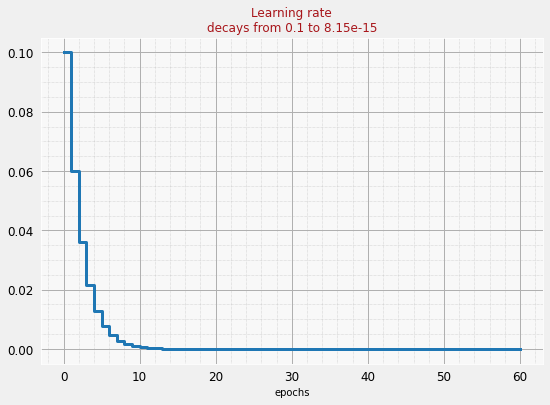

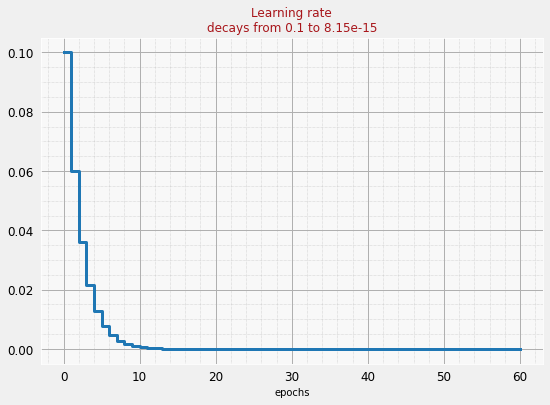

In [479]:
# lr decay function
def lr_decay(epoch):
  return 0.1 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, EPOCHS)

## Model for notes:

In [480]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(X_note.shape[1],)),

      # tf.keras.layers.Dense(60, use_bias=False),
      # tf.keras.layers.BatchNormalization(center=True, scale=False),
      # tf.keras.layers.Activation('relu'),
      # tf.keras.layers.Dropout(0.3),

      # tf.keras.layers.Dense(200, use_bias=False),
      # tf.keras.layers.BatchNormalization(center=True, scale=False),
      # tf.keras.layers.Activation('relu'),
      # tf.keras.layers.Dropout(0.3),
   
      tf.keras.layers.Dense(70, use_bias=True),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.Dropout(0.3),
   
      # tf.keras.layers.Dense(20, use_bias=False),
      # tf.keras.layers.BatchNormalization(center=True, scale=False),
      # tf.keras.layers.Activation('relu'),
      # tf.keras.layers.Dropout(0.2),
      
      tf.keras.layers.Dense(6, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 70)                5950      
_________________________________________________________________
batch_normalization_4 (Batch (None, 70)                210       
_________________________________________________________________
activation_4 (Activation)    (None, 70)                0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 70)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 6)                 426       
Total params: 6,586
Trainable params: 6,446
Non-trainable params: 140
_________________________________________________________________


In [481]:
Y = pd.get_dummies(y_note)
Y

0  1  2  3  4  5
0     0  0  0  1  0  0
1     0  0  0  0  0  1
2     0  0  0  0  0  1
3     0  0  0  0  1  0
4     0  0  1  0  0  0
...  .. .. .. .. .. ..
5353  1  0  0  0  0  0
5354  0  0  0  1  0  0
5355  1  0  0  0  0  0
5356  0  0  0  1  0  0
5357  0  0  0  0  1  0

[5358 rows x 6 columns]

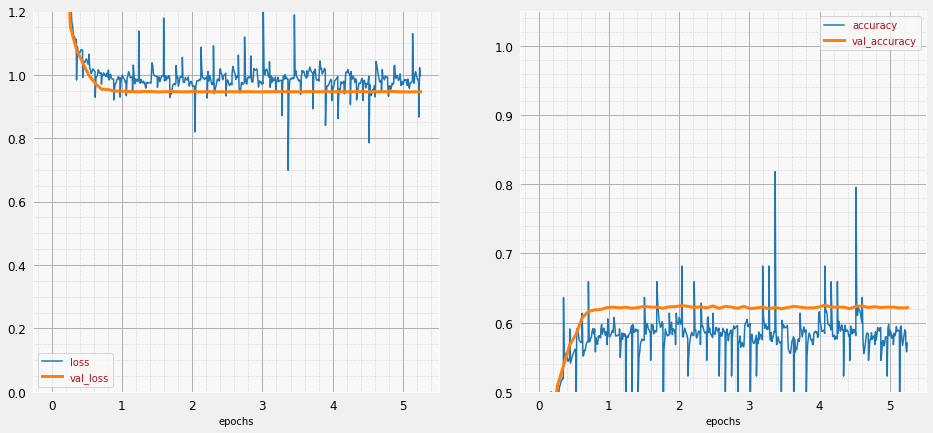

In [482]:
steps_per_epoch = X_note.shape[0]//BATCH_SIZE
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(X_note, Y, epochs=EPOCHS, validation_split=0.33, steps_per_epoch=steps_per_epoch,callbacks=[plot_training, lr_decay_callback])

In [483]:
print("train_accuracy:", max(history.history['accuracy']))
print("val_accuracy:", max(history.history['val_accuracy']))

train_accuracy: 0.6014313101768494
val_accuracy: 0.6252120137214661


## Model for strokes:

In [484]:
model2 = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(X_stroke.shape[1],)),

      # tf.keras.layers.Dense(60, use_bias=False),
      # tf.keras.layers.BatchNormalization(center=True, scale=False),
      # tf.keras.layers.Activation('relu'),
      # tf.keras.layers.Dropout(0.3),

      # tf.keras.layers.Dense(200, use_bias=False),
      # tf.keras.layers.BatchNormalization(center=True, scale=False),
      # tf.keras.layers.Activation('relu'),
      # tf.keras.layers.Dropout(0.3),
   
      tf.keras.layers.Dense(70, use_bias=True),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.Dropout(0.3),
   
      # tf.keras.layers.Dense(20, use_bias=False),
      # tf.keras.layers.BatchNormalization(center=True, scale=False),
      # tf.keras.layers.Activation('relu'),
      # tf.keras.layers.Dropout(0.2),
      
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model2.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model2.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 70)                5950      
_________________________________________________________________
batch_normalization_5 (Batch (None, 70)                210       
_________________________________________________________________
activation_5 (Activation)    (None, 70)                0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 70)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)                710       
Total params: 6,870
Trainable params: 6,730
Non-trainable params: 140
_________________________________________________________________


In [485]:
Y = pd.get_dummies(y_stroke)
Y

0  1  2  3  4  5  6  7  8  9
0     0  0  0  0  0  0  0  0  1  0
1     0  0  0  0  0  1  0  0  0  0
2     0  0  0  1  0  0  0  0  0  0
3     0  0  0  0  0  0  0  0  0  1
4     0  0  0  0  0  0  0  0  0  1
...  .. .. .. .. .. .. .. .. .. ..
6856  0  0  0  0  0  0  0  0  1  0
6857  0  0  0  0  0  0  0  0  1  0
6858  0  0  0  0  0  1  0  0  0  0
6859  0  0  0  0  1  0  0  0  0  0
6860  0  0  0  1  0  0  0  0  0  0

[6861 rows x 10 columns]

In [486]:
X_stroke

array([[0.        , 0.1709388 , 0.28984014, ..., 0.33005879, 0.36324556,
        0.37510822],
       [0.        , 0.50808936, 0.55169331, ..., 0.26347378, 0.22689413,
        0.28802185],
       [0.        , 0.92876484, 0.6646746 , ..., 0.17246604, 0.18691139,
        0.1195372 ],
       ...,
       [0.        , 0.2721275 , 0.45604947, ..., 0.12224463, 0.11875336,
        0.15886304],
       [0.        , 0.552315  , 0.79940175, ..., 0.43830752, 0.54809239,
        0.4995174 ],
       [0.        , 0.62413277, 0.20217398, ..., 0.25468548, 0.23495432,
        0.30250144]])

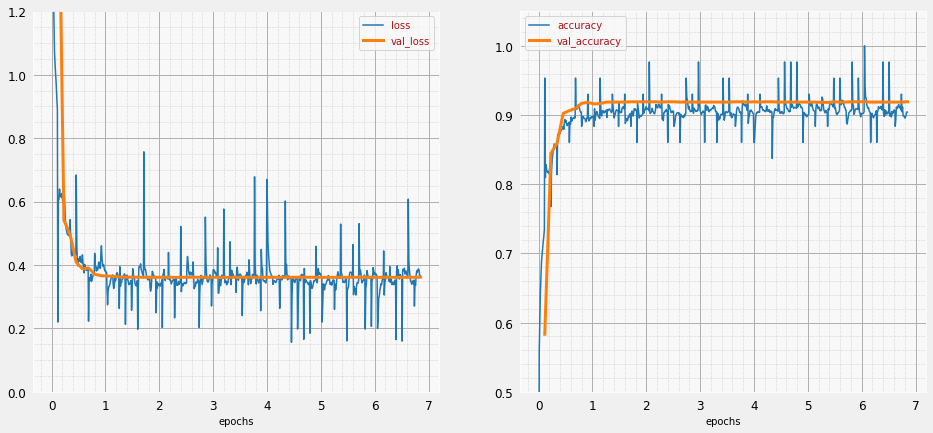

In [487]:
steps_per_epoch = X_stroke.shape[0]//BATCH_SIZE
print("Steps per epoch: ", steps_per_epoch)

history = model2.fit(X_stroke, Y, epochs=EPOCHS, validation_split=0.33, steps_per_epoch=steps_per_epoch,callbacks=[plot_training, lr_decay_callback])

As the final step, let's also print the **confusion matrix**

In [488]:
print("train_accuracy:", max(history.history['accuracy']))
print("val_accuracy:", max(history.history['val_accuracy']))

train_accuracy: 0.9118798971176147
val_accuracy: 0.9192053079605103


# Using spectrogram CNN based model

In [489]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [490]:
!ls

 Assignment1.ipynb		        _readme_and_license.txt
'Copia de Assignment1.ipynb'	        segments
'Copia de Copia de Assignment1.ipynb'   segments_note
 mridangam_stroke_1.0		        segments_stroke


In [491]:
data_dir = pathlib.Path('segments_note')
files = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = []
for file in files:
  element = file.split('_')[0]
  if not(element == 'data.csv'):
    if element not in commands:
      commands.append(element)
# myset = set(commands)
print(commands)

['E', 'D#', 'C#', 'D', 'B', 'C']


In [492]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
filenames = tf.random.shuffle(filenames)
filenames

<tf.Tensor: shape=(6861,), dtype=string, numpy=
array([b'segments_note/E_1009.wav', b'segments_note/C#_386.wav',
       b'segments_note/D#_1276.wav', ..., b'segments_note/E_272.wav',
       b'segments_note/C_625.wav', b'segments_note/C_395.wav'],
      dtype=object)>

In [493]:
train_files = filenames[:5000]
val_files = filenames[5000: 5000 + 1000]
test_files = filenames[-1162:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 5000
Validation set size 1000
Test set size 1162


In [494]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [495]:
def get_label(file_path):
  parts = tf.strings.split(tf.strings.split(file_path, os.path.sep)[1], '_')
  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[0]

In [496]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [497]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

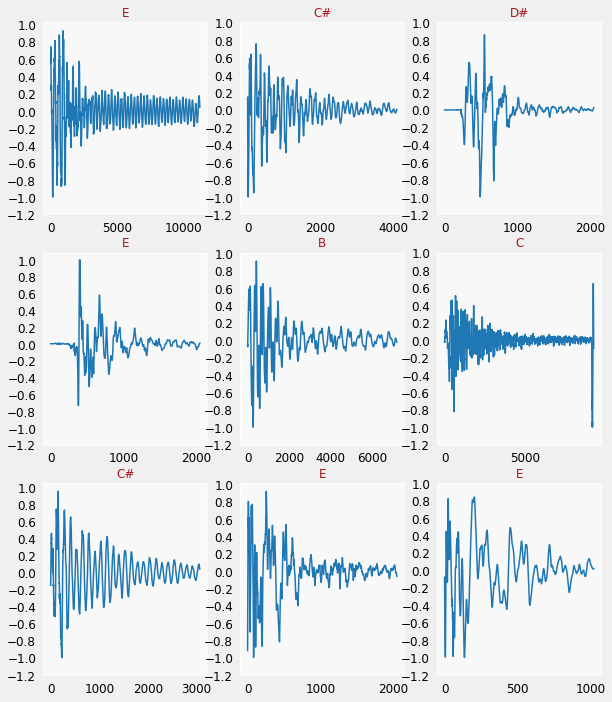

In [498]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [499]:
def get_spectrogram(waveform):
  waveform = waveform[0:16000]
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [500]:
waveform_ds.flat_map

<bound method DatasetV2.flat_map of <ParallelMapDataset shapes: ((None,), ()), types: (tf.float32, tf.string)>>

In [501]:
for waveform, label in waveform_ds.take(4):
  label = label.numpy().decode('utf-8')
  print(label)
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=44100))

E
C#
D#
E
Label: E
Waveform shape: (2048,)
Spectrogram shape: (124, 129)
Audio playback


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


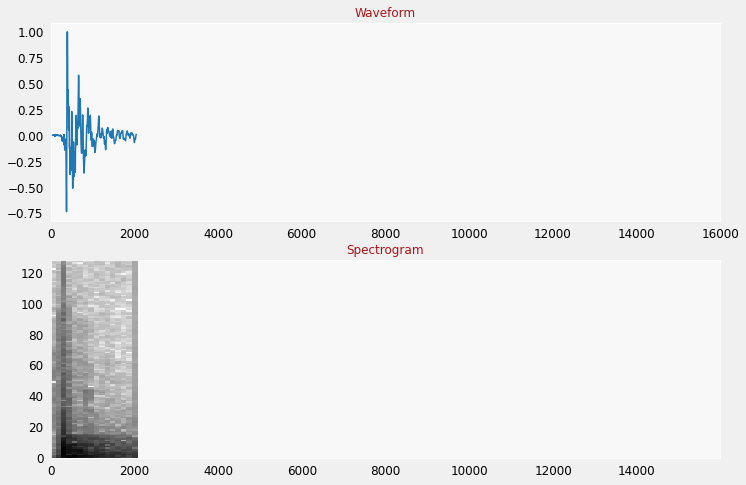

In [502]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(16000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)
  
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [503]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [504]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


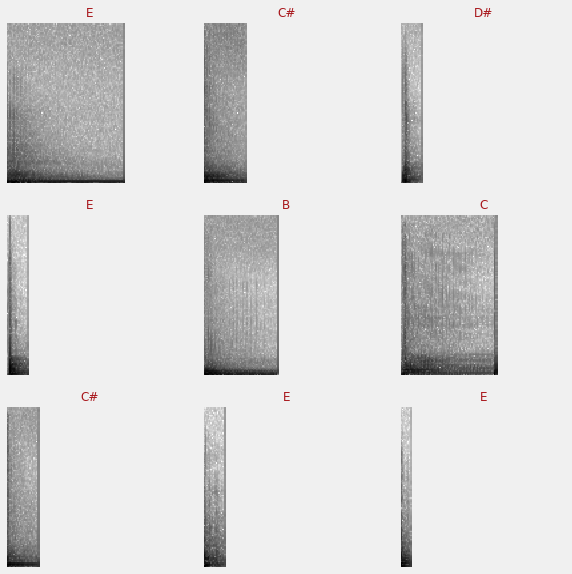

In [505]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

In [506]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [507]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [508]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [509]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [510]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model3 = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model3.summary()

Input shape: (124, 129, 1)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_5 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_6 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)       

In [511]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [512]:
EPOCHS = 60
history = model3.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/60
79/79 [==============================] - 15s 186ms/step - loss: 1.6660 - accuracy: 0.3000 - val_loss: 1.2675 - val_accuracy: 0.4840
Epoch 2/60
79/79 [==============================] - 1s 8ms/step - loss: 1.2851 - accuracy: 0.4589 - val_loss: 1.0224 - val_accuracy: 0.5890
Epoch 3/60
79/79 [==============================] - 1s 7ms/step - loss: 1.0950 - accuracy: 0.5310 - val_loss: 0.9444 - val_accuracy: 0.6250
Epoch 4/60
79/79 [==============================] - 1s 7ms/step - loss: 1.0294 - accuracy: 0.5387 - val_loss: 0.9277 - val_accuracy: 0.6280
Epoch 5/60
79/79 [==============================] - 1s 7ms/step - loss: 0.9859 - accuracy: 0.5604 - val_loss: 0.8822 - val_accuracy: 0.6250
Epoch 6/60
79/79 [==============================] - 1s 7ms/step - loss: 0.9610 - accuracy: 0.5705 - val_loss: 0.8687 - val_accuracy: 0.6380
Epoch 7/60
79/79 [==============================] - 1s 7ms/step - loss: 0.9426 - accuracy: 0.5799 - val_loss: 0.8451 - val_accuracy: 0.6360
Epoch 8/60
79/79 

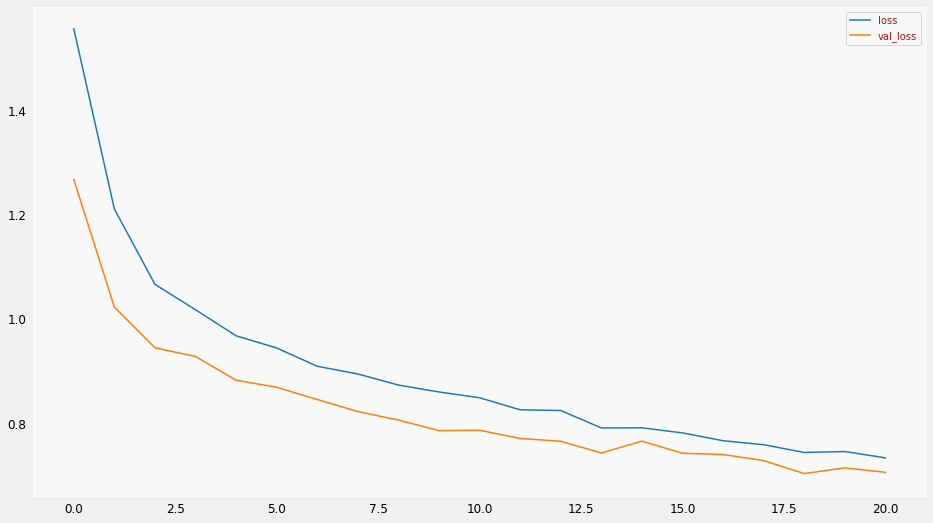

In [513]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [514]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [515]:
y_pred = np.argmax(model3.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 73%


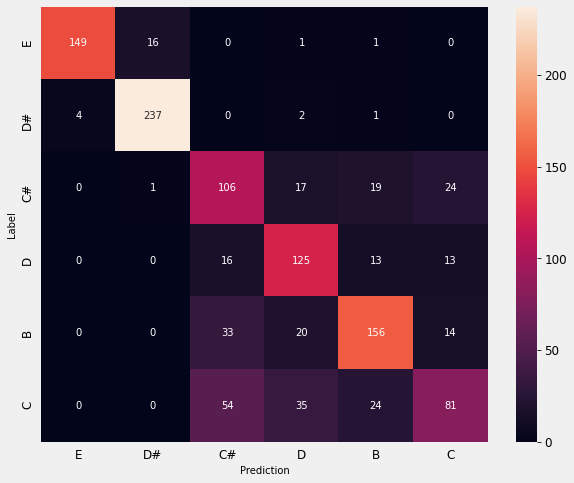

In [516]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

What about the strokes?

In [517]:
data_dir = pathlib.Path('segments_stroke')
files = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = []
for file in files:
  element = file.split('_')[0]
  if not(element == 'data.csv'):
    if element not in commands:
      commands.append(element)
# myset = set(commands)
print(commands)

['dheem', 'cha', 'bheem', 'thom', 'num', 'dhin', 'ta', 'tha', 'thi', 'tham']


In [518]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
filenames = tf.random.shuffle(filenames)
filenames

<tf.Tensor: shape=(6861,), dtype=string, numpy=
array([b'segments_stroke/tha_440.wav', b'segments_stroke/thi_1611.wav',
       b'segments_stroke/thi_1922.wav', ...,
       b'segments_stroke/ta_142.wav', b'segments_stroke/dheem_178.wav',
       b'segments_stroke/thi_60.wav'], dtype=object)>

In [519]:
train_files = filenames[:5000]
val_files = filenames[5000: 5000 + 1000]
test_files = filenames[-1162:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 5000
Validation set size 1000
Test set size 1162


In [520]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

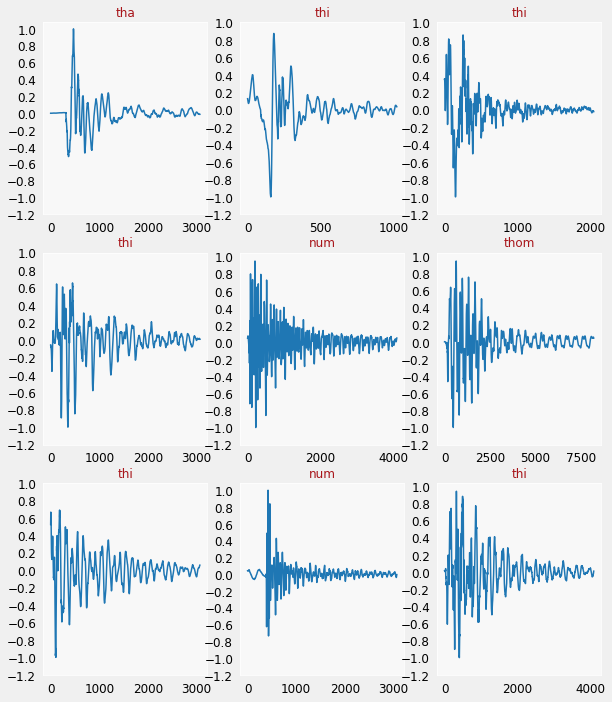

In [521]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [522]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


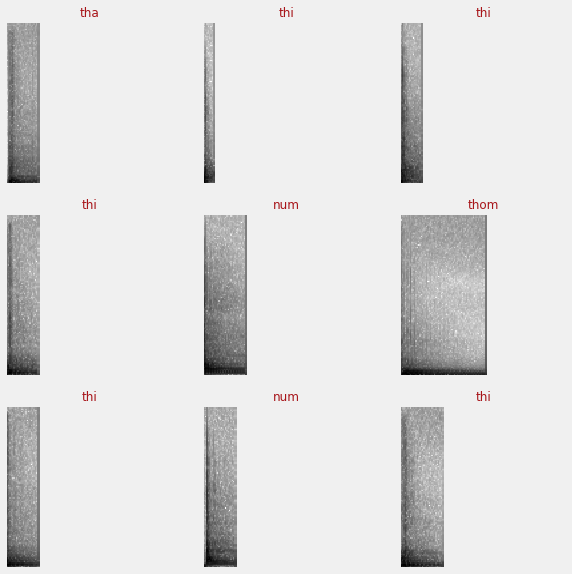

In [523]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

In [524]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [525]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [526]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [527]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model4 = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model4.summary()

Input shape: (124, 129, 1)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_6 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_7 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)       

In [528]:
model4.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [529]:
EPOCHS = 60
history = model4.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/60
79/79 [==============================] - 15s 182ms/step - loss: 1.6355 - accuracy: 0.4318 - val_loss: 0.7676 - val_accuracy: 0.7360
Epoch 2/60
79/79 [==============================] - 1s 8ms/step - loss: 0.9354 - accuracy: 0.6825 - val_loss: 0.6115 - val_accuracy: 0.8030
Epoch 3/60
79/79 [==============================] - 1s 7ms/step - loss: 0.8033 - accuracy: 0.7422 - val_loss: 0.5366 - val_accuracy: 0.8210
Epoch 4/60
79/79 [==============================] - 1s 7ms/step - loss: 0.6970 - accuracy: 0.7818 - val_loss: 0.4627 - val_accuracy: 0.8570
Epoch 5/60
79/79 [==============================] - 1s 7ms/step - loss: 0.6387 - accuracy: 0.8129 - val_loss: 0.4304 - val_accuracy: 0.8710
Epoch 6/60
79/79 [==============================] - 1s 7ms/step - loss: 0.5886 - accuracy: 0.8271 - val_loss: 0.4130 - val_accuracy: 0.8840
Epoch 7/60
79/79 [==============================] - 1s 7ms/step - loss: 0.5780 - accuracy: 0.8364 - val_loss: 0.4089 - val_accuracy: 0.8660
Epoch 8/60
79/79 

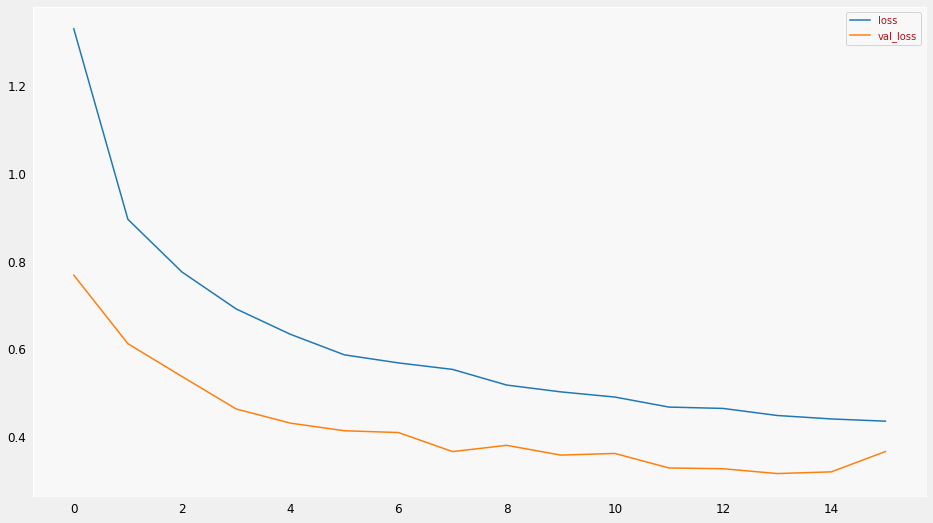

In [530]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [531]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [532]:
y_pred = np.argmax(model4.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 87%


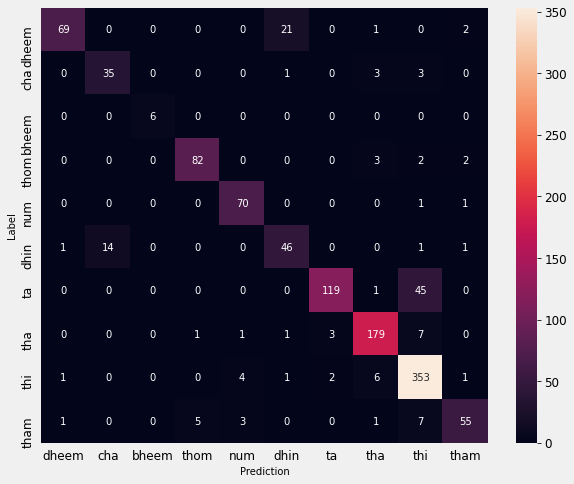

In [533]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Summary:

## Best model tryied for note classification:
SVM Radial kernel, C = 500
* accuracy- note_all_features  : 0.7444884115319389
* accuracy- note_selected_features  : 0.747880158281515

Better results for selected 75 features


## Best model tryied for stroke classification:
SVM Linear kernel, C = 500
* accuracy- stroke_all_features  : 0.9306843267108168
* accuracy- stroke_selected_features  : 0.928476821192053

However, in this case the selected features do not perform better that in the whole set of features.

## About CNNs:

Probably the main problem with my architecture is that I cropped the signal in the 16000 of a 44100hz. This probably caused that the tone features that could be infered in the filters of the CNN were not well learned, since only the attack was watched, and not the DSR of the signal, where probably is most of the tonal information. 

Regathless the resutls, it was really fun to experiment with sklearn and Keras. I am looking forward for the feedback.